# Global Meridional Overturning (MOC)

This notebook plots the global MOC in depth and isopycnal (`rho2`) space as well as a break down of the Indo-Pacific and Atlantic basin.

In [1]:
import os
import datetime
import itertools
import cmip_basins
import cftime
import om4common

/nbhome/ogrp/python/envs/py311_20240513/lib/python3.11/site-packages/omlabs/diags/__init__.py:16: UserWarning: Unable to import diagnostic: surface_wmt
  warnings.warn(f"Unable to import diagnostic: {_diag}")


In [2]:
import VerticalSplitScale

In [3]:
config = {
    "startyr": "1981",
    "endyr": "2000",
    "dora_id": "odiv-382",
    "pathPP": None,
}

MAR will pass for environment variables to the script when running via the web engine:

* `MAR_STARTYR`: Beginning year of analysis from model
* `MAR_ENDYR`: Ending year of analysis from model
* `MAR_DORA_ID`: The experiment ID in the database
* `MAR_PATHPP`: The top-level path to the post-processing experiment directory of the experiment

The block below will use values passed in by Dora but default to the values defined above in `config`. This is useful for interactive usage and debugging.

If executed from Dora, there will also be a `DORA_EXECUTE` variable that is set.

In [4]:
for k, v in config.items():
    config[k] = (
        os.environ[f"MAR_{k.upper()}"]
        if f"MAR_{k.upper()}" in os.environ.keys()
        else v
    )

### Import Python Modules

In [5]:
import doralite
import glob
import subprocess

import numpy as np
import xarray as xr
import matplotlib.pyplot as plt

In [6]:
import momgrid
os.environ["MOMGRID_WEIGHTS_DIR"] = "/nbhome/John.Krasting/grid_weights"

### Definie Local Parameters

In [7]:
# Define some local variables. These are taken from the doralite object
# or they can be defined locally

# 1. List of all experiments to consider
experiments = [doralite.dora_metadata(x) for x in config["dora_id"].split(",")]

#pathPP = experiment["pathPP"]
#expName = experiment["expName"]

# Define start and end years
start = int(config["startyr"])
end = int(config["endyr"])

print(start,end)

1981 2000


### Determine What Files to Load

In [8]:
def is_in_range(file,start,end):
    start = int(start)
    end = int(end)
    target = set(list(range(start,end+1)))
    fname = os.path.basename(file)
    times = fname.split(".")[1]
    times = times.split("-")
    times = [int(x[0:4]) for x in times]
    candidate = set(list(range(times[0],times[1]+1)))
    return len(candidate.intersection(target)) > 0

In [9]:
dset = "av"

In [10]:
datafiles = []
staticfiles = []

for experiment in experiments:

    _pathPP = experiment["pathPP"]

    ddict = {component: {} for component in ["ocean_annual_z", "ocean_annual_rho2"]}
    ddict["ocean_annual_z"]["variables"] = ["vmo"]
    ddict["ocean_annual_rho2"]["variables"] = ["vmo", "volcello"]

    for component in ddict:
        # print(component)

        if dset == "ts":
            chunks = os.listdir(
                os.path.join(_pathPP, component, dset, component.split("_")[1])
            )  # ts
        else:
            chunks = os.listdir(os.path.join(_pathPP, component, dset))  # av
        if len(chunks) > 1:
            print(
                "Warning: More than one chunk size available. Using %s"
                % sorted(chunks)[-1]
            )
        chunk = sorted(chunks)[-1]

        filelist = []

        if dset == "ts":
            for varname in ddict[component]["variables"]:
                # print(varname)
                files = sorted(
                    glob.glob(
                        f"{_pathPP}{component}/{dset}/{component.split('_')[1]}/{chunk}/{component}.*.{varname}.nc",
                        recursive=True,
                    )
                )  # ts
        else:
            files = sorted(
                glob.glob(
                    f"{_pathPP}{component}/{dset}/{chunk}/{component}.*.nc",
                    recursive=True,
                )
            )  # av

            files_in_range = [x for x in files if is_in_range(x, start, end)]
            filelist = filelist + files_in_range
        ddict[component]["filelist"] = filelist

    filelist = []
    for component in ddict:
        filelist = filelist + ddict[component]["filelist"]

    _static = f"{component}/{component}.static.nc"
    _staticfile = f"{_pathPP}{_static}"

    staticfiles.append(_staticfile)
    datafiles.append(filelist)

In [11]:
allfiles = sorted(list(itertools.chain(*datafiles)) + staticfiles)
_ = [print(x) for x in allfiles]

/archive/John.Krasting/fre_om5/FMS2023.01_om5_20230720/om5_b00_ryf_branch_241/gfdl.ncrc5-intel23-prod/pp/ocean_annual_rho2/av/annual_5yr/ocean_annual_rho2.1978-1982.ann.nc
/archive/John.Krasting/fre_om5/FMS2023.01_om5_20230720/om5_b00_ryf_branch_241/gfdl.ncrc5-intel23-prod/pp/ocean_annual_rho2/av/annual_5yr/ocean_annual_rho2.1983-1987.ann.nc
/archive/John.Krasting/fre_om5/FMS2023.01_om5_20230720/om5_b00_ryf_branch_241/gfdl.ncrc5-intel23-prod/pp/ocean_annual_rho2/av/annual_5yr/ocean_annual_rho2.1988-1992.ann.nc
/archive/John.Krasting/fre_om5/FMS2023.01_om5_20230720/om5_b00_ryf_branch_241/gfdl.ncrc5-intel23-prod/pp/ocean_annual_rho2/av/annual_5yr/ocean_annual_rho2.1993-1997.ann.nc
/archive/John.Krasting/fre_om5/FMS2023.01_om5_20230720/om5_b00_ryf_branch_241/gfdl.ncrc5-intel23-prod/pp/ocean_annual_rho2/av/annual_5yr/ocean_annual_rho2.1998-2002.ann.nc
/archive/John.Krasting/fre_om5/FMS2023.01_om5_20230720/om5_b00_ryf_branch_241/gfdl.ncrc5-intel23-prod/pp/ocean_annual_rho2/ocean_annual_rho2

### DMgetting Files

Dora cannot issue calls to dmget

In [12]:
if not "DORA_EXECUTE" in os.environ.keys():
    print("Calling dmget on files ...")
    cmd = ["dmget"]+allfiles
    _ = subprocess.check_output(cmd)

Calling dmget on files ...


### Load model data and grid

In [13]:
dsets = []

for n,filelist in enumerate(datafiles):
    filelist = [x for x in filelist if "ocean_annual_z" in x]
    #_ds = momgrid.Gridset(filelist, force_symmetric=True, return_corners=True).data
    #_ds = _ds.sel(time=slice(f"{str(start).zfill(4)}-01-01",f"{str(end).zfill(4)}-12-31"))
    
    ds = xr.open_mfdataset(filelist, use_cftime=True)
    dss = xr.open_dataset(staticfiles[n])

    dsnew = xr.Dataset()
    dsnew["vmo"] = ds.vmo
    dsnew["z_i"] = ds.z_i
    dsnew["deptho"] = xr.DataArray(dss["deptho"].values,dims=("yh","xh"))
    dsnew["geolon_v"] = xr.DataArray(dss["geolon_v"].values,dims=("yq","xh"))
    dsnew["geolat_v"] = xr.DataArray(dss["geolat_v"].values,dims=("yq","xh"))

    if (len(dsnew.yq) == 1081) | (len(dsnew.yq) == 1162):
        dsnew = dsnew.isel({"yq":slice(1,None)})

    dsnew = dsnew.mean("time").load()

    dsnew.attrs["date_range"] = f"Years {str('-').join([str(x) for x in om4common.date_range(ds)])}"
    
    dsets.append(dsnew)  

### Overturning in depth space (`ocean_annual_z`)

In [14]:
rho0 = 1035.

def calc_moc_z(vmo):
    # Sum over the zonal direction and integrate from bottom
    # Reverse vertical (density) axis and integrate
    integ_layers = vmo.sum("xh").reindex(z_l=vmo.z_l[::-1]).cumsum("z_l")
    # The result of the integration over layers is evaluated at the interfaces
    # with psi = 0 as the bottom boundary condition for the integration
    bottom_condition = xr.zeros_like(integ_layers.isel({"z_l": 0}))
    # combine bottom condition with data array
    psi_raw = xr.concat(
        [integ_layers.reindex(z_l=integ_layers.z_l[::-1]), bottom_condition], dim="z_l"
    )
    # need to rechunk to new size
    psi_raw = psi_raw.chunk({'z_l': len(psi_raw['z_l'])})
    # rename to correct dimension and add correct vertical coordinate
    psi = -psi_raw.rename({'z_l': 'z_i'}).transpose('z_i','yq')
    psi['z_i'] = ds.z_i
    psi.name = 'psi'
    # Convert kg.s-1 to Sv (1e6 m3.s-1)
    moc_z = psi / rho0 / 1.0e6
    #moc_z = moc_z.mean('time').load()
    return moc_z

In [15]:
def plot_panel(ax, y, z, psi, depth, domain):

    if domain == "atlarc":
        levels = np.arange(-28, 30, 2)
    elif domain == "global":
        levels = np.arange(-40, 42, 2)
        
    cb = ax.contourf(y, z, psi, levels=levels, cmap="RdBu_r")

    # Setting y-axis limits to avoid singular transformation warning for future calls
    ax.set_ylim([np.min(z) - 500, np.max(z) + 500])

    cs = ax.contour(y, z, psi, levels=levels, colors="k", linewidths=0.3)
    zero_contours = ax.contour(y, z, psi, levels=[0], colors="blue", linewidths=0)

    ax.set_yscale("splitscale", zval=[6500.0, 2000.0, 0.0])
    plt.axhline(y=2000, color="k", linestyle="dashed", linewidth=0.8)

    _ = ax.fill_between(y, depth, 6750, color="gray", zorder=2)

    plt.colorbar(cb)
    
    if domain == "atlarc":
        Y, Z = np.meshgrid(y, z)
        mask = (Y >= 20) & (Y <= 80) & (Z >= 500) & (Z <= 2000)
        _psi = psi.values
        max_psi = np.max(_psi[mask])
        max_index = np.unravel_index(np.argmax(_psi[mask]), _psi[mask].shape)
        max_y = Y[mask][max_index]
        max_z = Z[mask][max_index]
        
        square_size = 10
        ax.plot(
            max_y,
            max_z,
            marker="s",
            color="yellow",
            markersize=square_size + 5,
            markeredgewidth=2,
            markeredgecolor="yellow",
            markerfacecolor="none",
        )
        ax.annotate(
            f"{max_psi:.1f} Sv",
            xy=(max_y, max_z),
            xytext=(10, 10),
            textcoords="offset points",
            arrowprops=dict(arrowstyle="->", color="black"),
            bbox=dict(facecolor="white", edgecolor="black", boxstyle="round,pad=0.2", linewidth=0.5, alpha=0.7),
        )
    
        z_values = []
        for seg in zero_contours.allsegs[0]:  # Iterate over the segments for the zero level
            for x, z_val in seg:
                if (
                    20 <= x <= 55 and 2500 <= z_val <= 4000
                ):  # Filter points by y and z range
                    z_values.append(z_val)
    
        mean_z = np.mean(z_values) if z_values else None
    
        if mean_z:
            ax.annotate(
                f"Mean Depth:\n{mean_z:.0f} m",
                xy=(40, mean_z),
                xytext=(-10, -30),
                textcoords="offset points",
                arrowprops=dict(arrowstyle="->", color="black"),
                bbox=dict(facecolor="white", edgecolor="black", boxstyle="round,pad=0.2", linewidth=0.5, alpha=0.7),
            )

In [16]:
def prepare_data_z(ds,domain="global"):

    # Transpose the depth from the t-grid to the v-grid (just for plotting)
    ds["deptho"] = xr.DataArray(ds.deptho.values,dims=("yq","xh"))

    if domain == "atlarc":
        # Calculate the basin mask on the v-grid
        basin = cmip_basins.generate_basin_codes(ds,lon="geolon_v", lat="geolat_v")
        mask = xr.where((basin == 2) | (basin == 4) | (basin == 6) | (basin == 7) | (basin == 8) | (basin ==9) , 1., np.nan)
    elif domain == "global":
        mask = 1.
    else:
        raise ValueError(f"Invalid domain {domain}")

    y = (ds.geolat_v * mask).mean("xh")
    y = xr.DataArray(y.values, dims=("y"), coords={"y":y.values})
    
    yloc = xr.where(y.isnull(), False, True)
    
    z = ds.z_i
    
    psi = calc_moc_z(ds.vmo*mask)
    psi = xr.DataArray(psi.values,dims=("z","y"), coords={"z":z.values, "y":y.values})
    psi = psi[:,yloc]
    
    depth = xr.DataArray((ds.deptho*mask).max("xh").values, dims=("y"), coords={"y":y.values})
    depth = depth[yloc]
    y = y[yloc]

    return (y, z, psi, depth, domain)

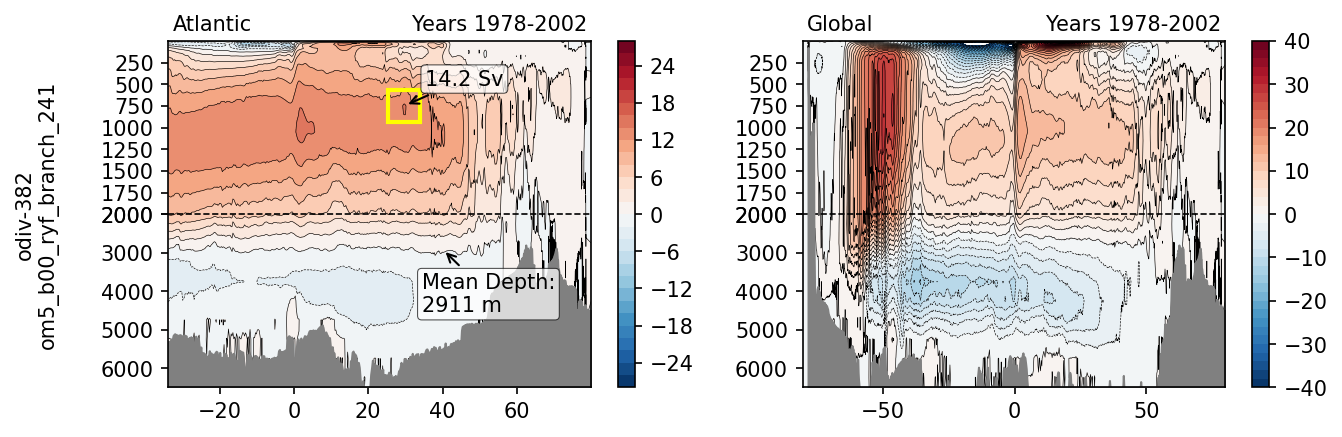

In [17]:
nexp = len(dsets)

fig = plt.figure(figsize=(10,3*nexp), dpi=150)

plotcounter = 1
for n,ds in enumerate(dsets):

    ax = plt.subplot(nexp,2,plotcounter)
    plot_panel(ax, *prepare_data_z(ds, domain="atlarc"))
    if "date_range" in ds.attrs.keys():
        date_range = ds.attrs["date_range"]
    else:
        date_range = ""
    ax.text(.99,1.03,date_range,ha="right", transform=ax.transAxes)
    ax.text(.01,1.03,f"Atlantic",ha="left", transform=ax.transAxes)
    plotcounter += 1

    ax.set_ylabel(config["dora_id"].split(",")[n]+"\n"+experiments[n]["expName"], labelpad=20)

    ax = plt.subplot(nexp,2,plotcounter)
    plot_panel(ax, *prepare_data_z(ds, domain="global"))
    ax.text(.99,1.03,date_range,ha="right", transform=ax.transAxes)
    ax.text(.01,1.03,f"Global",ha="left", transform=ax.transAxes)
    plotcounter += 1

### Overturning in density space (`ocean_annual_rho2`)

ds = ddict["ocean_annual_rho2"]["ds"]
vmo = ds.vmo.where(ds.vmo<1e14)

# Sum over the zonal direction and integrate along density
integ_layers = (vmo.sum('xh').cumsum('rho2_l') - vmo.sum('xh').sum('rho2_l'))/rho0/1.0e6 + 0.1

# The result of the integration over layers is evaluated at the interfaces
# with psi = 0 as the bottom boundary condition for the integration
bottom_condition = xr.zeros_like(integ_layers.isel({'rho2_l': 0}))

# combine bottom condition with data array
#psi_raw = xr.concat([integ_layers, bottom_condition], dim='rho2_l')
psi_raw = xr.concat([bottom_condition, integ_layers], dim='rho2_l')

# need to rechunk to new size
psi_raw = psi_raw.chunk({'rho2_l': len(psi_raw['rho2_l'])})

# rename to correct dimension and add correct vertical coordinate
psi = psi_raw.rename({'rho2_l': 'rho2_i'}).transpose('time','rho2_i','yq')
psi['rho2_i'] = ds.rho2_i
psi.name = 'psi'
moc_rho2 = psi.mean('time').load()

from om4labs.m6plot.formatting import VerticalSplitScale

fig, ax = plt.subplots(figsize=(10,5))
moc_rho2.sel(rho2_i=slice(1027.5,None)).plot(ax=ax, yincrease=False,vmin=-30,vmax=30,cmap='RdBu_r',
                                             cbar_kwargs={'ticks': np.arange(-30,35,5)})
moc_rho2.sel(rho2_i=slice(1027.5,None)).plot.contour(ax=ax, yincrease=False, levels=contours, colors='k', linewidths=1)
ax.set_yscale('splitscale', zval=[1037.25, 1036.5, 1028.8])
ax.invert_yaxis()
ax.set_title(experiment['expName'])
plt.show()

### Establish a Dictionary to Store Scalar Metrics

stats_dict = {}
stats_dict["metadata"] = {
    "expName": str(expName),
    "created": datetime.datetime.now().isoformat(),
    "starttime": str(starttime.values),
    "endtime": str(endtime.values),
}
stats_dict["results"] = {}
stats_dict

### Write Stats to a File

if not "DORA_EXECUTE" in os.environ.keys():
    import yaml
    yml = yaml.dump(stats_dict)
    with open('oisst_stats.yaml', 'w') as file:
        file.write(yml)
    file.close()
    print(yml)